## Threshold for condition:
We want to decide wether a problem is unique or non unique depending on this threshold.

### Non uniqueness

 We choose the threshoold $T$ as 
 $$T = \frac{\tilde{\sigma}_1}{\sqrt{E}} $$
where $E = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is bigger than T the function u should be nonunique.

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt

In [2]:
"""
n: number of data points used for approximation/ order
k: number of lagrange coefficient
l: input to lagrange coefficient: x = x_l = x+ hl
"""
#Computes the coefficients of the derivitve of the kth Lagrangian Coefficients
#These are also the coefficients used for finite differences
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0        
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                  if i!=k and i!=j:
                    tmp *=(l-i)/(k-i)
                    #print(f"l-k = {l}-{i}")
            tmp*=1.0/(k-j)
            erg+=tmp
    return erg
    
#Sums up the above coefficients
#needed for measurment error
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg

# Approximation error central differences: reduces with higher order n
def appr_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    bound = (np.math.factorial(int(n/2))**2)/np.math.factorial(n+1)
    return bound
    
# Approximation error backward differences: reduces with higher order n
def appr_error_backward_diff(n):
    return 1/(n+1)

# Measurement error central differences
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg



"""
eps: measurement error+round of error (Does it make sense to add machine precision?)
h: dx for equispaced data
M: bound on (order+1)th derivative
"""
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
    #print(f" C_meas*eps/h + (h**order)*M*C_app = {C_meas:2.3e}*{eps:2.3e}/{h:2.3e} + {h**order:2.3e}*{M:2.3e}*{C_app:2.3e}")    
    return C_meas*eps/h + (h**order)*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

"""
eps_two: ||u-u_noise||_2 two norm
eps_infty: ||u-u_noise||_infty infinity norm
h: dx for equispaced data
number_datapoints: number of total datapoints where u is evaluated
M: bound on nth derivative depending on the order
"""
def error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order):
    E = eps_two**2 + number_datapoints*error_bound(eps_infty,h,M,order)**2
    return E


In [3]:
def calc_threshold(eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_meas=meas_error_backward_diff(order)
    return 1/(eps/h+h**order)

def calc_threshold2(eps_two,eps_infty,h,number_datapoints,M,order=2): 
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    return 1/np.sqrt(E)

In [4]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-5, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [5]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 5.256461815550567
Singular values of g: (89.77014070295225, 8.651900629800207e-15)
sv_max/sv_min: 1.038e+16


In [6]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 5.256461815550567
Singular values of g: (89.77014070295225, 8.651900629800207e-15)
sv_max/sv_min: 1.038e+16


True ratio: 1.038e+16
Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
0
0.0
	  	 2 	 	 4.352e+04 	 2.401e+03 	 5.481e+01
	  	 3 	 	 4.214e+06 	 1.176e+05 	 1.791e+03
	  	 4 	 	 2.803e+08 	 5.765e+06 	 6.580e+05
	  	 5 	 	 1.416e+10 	 2.825e+08 	 6.448e+06
	  	 6 	 	 8.507e+11 	 1.384e+10 	 7.319e+09
	  	 7 	 	 4.642e+13 	 6.733e+11 	 1.361e+10
	  	 8 	 	 3.410e+13 	 2.441e+13 	 8.727e+11
	  	 9 	 	 2.413e+13 	 8.700e+13 	 1.362e+10


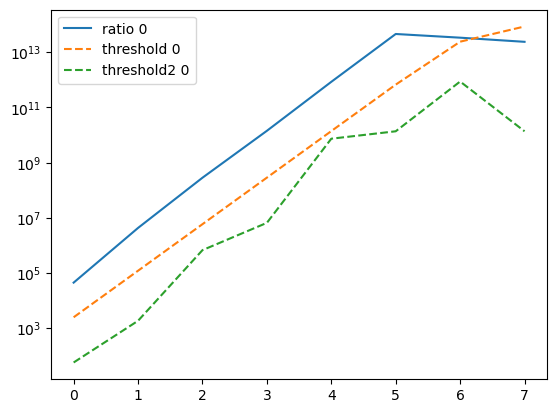

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-10
6.4766486219605835e-09
	  	 2 	 	 4.352e+04 	 2.401e+03 	 5.481e+01
	  	 3 	 	 4.217e+06 	 1.173e+05 	 1.765e+03
	  	 4 	 	 1.917e+08 	 5.050e+06 	 2.975e+05
	  	 5 	 	 1.993e+08 	 3.559e+07 	 4.736e+04
	  	 6 	 	 1.485e+08 	 4.060e+07 	 4.442e+05
	  	 7 	 	 9.638e+07 	 4.071e+07 	 1.770e+04
	  	 8 	 	 5.914e+07 	 4.072e+07 	 3.909e+05
	  	 9 	 	 3.463e+07 	 4.072e+07 	 6.036e+03


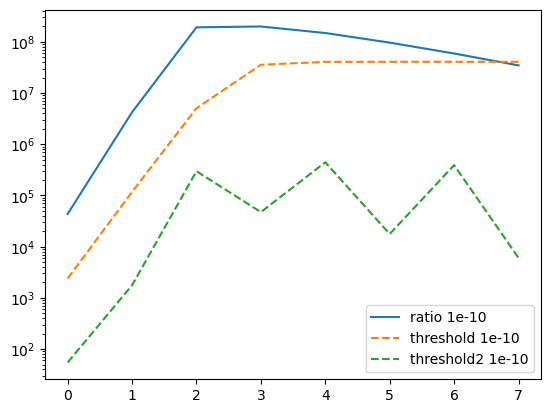

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-09
6.422463751262255e-08
	  	 2 	 	 4.351e+04 	 2.400e+03 	 5.477e+01
	  	 3 	 	 4.199e+06 	 1.142e+05 	 1.555e+03
	  	 4 	 	 2.625e+07 	 2.342e+06 	 4.870e+04
	  	 5 	 	 1.903e+07 	 3.890e+06 	 4.619e+03
	  	 6 	 	 1.384e+07 	 3.944e+06 	 4.303e+04
	  	 7 	 	 9.099e+06 	 3.945e+06 	 1.714e+03
	  	 8 	 	 5.778e+06 	 3.945e+06 	 3.787e+04
	  	 9 	 	 3.518e+06 	 3.945e+06 	 5.848e+02


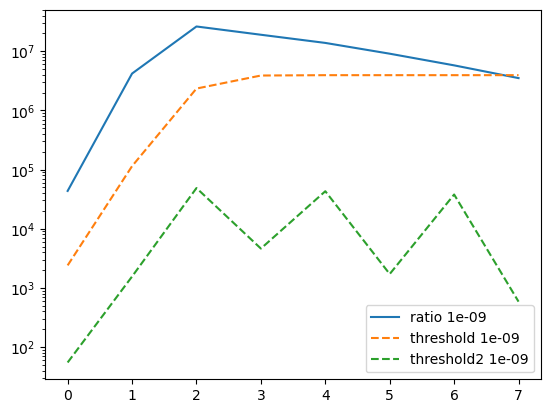

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-08
6.372009434690132e-07
	  	 2 	 	 4.350e+04 	 2.388e+03 	 5.447e+01
	  	 3 	 	 2.346e+06 	 9.279e+04 	 7.591e+02
	  	 4 	 	 2.673e+06 	 4.081e+05 	 5.805e+03
	  	 5 	 	 1.892e+06 	 4.386e+05 	 5.147e+02
	  	 6 	 	 1.369e+06 	 4.392e+05 	 4.792e+03
	  	 7 	 	 8.971e+05 	 4.392e+05 	 1.909e+02
	  	 8 	 	 5.685e+05 	 4.392e+05 	 4.217e+03
	  	 9 	 	 3.475e+05 	 4.392e+05 	 6.512e+01


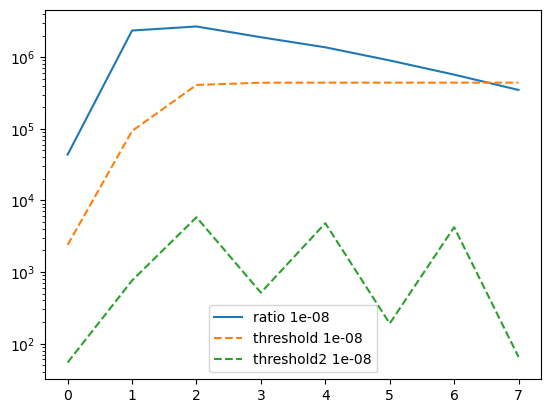

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-07
6.362437916497777e-06
	  	 2 	 	 4.323e+04 	 2.290e+03 	 5.194e+01
	  	 3 	 	 3.019e+05 	 3.483e+04 	 1.371e+02
	  	 4 	 	 2.916e+05 	 4.906e+04 	 6.591e+02
	  	 5 	 	 2.059e+05 	 4.947e+04 	 5.798e+01
	  	 6 	 	 1.497e+05 	 4.948e+04 	 5.398e+02
	  	 7 	 	 9.772e+04 	 4.948e+04 	 2.150e+01
	  	 8 	 	 6.179e+04 	 4.948e+04 	 4.750e+02
	  	 9 	 	 3.719e+04 	 4.948e+04 	 7.336e+00


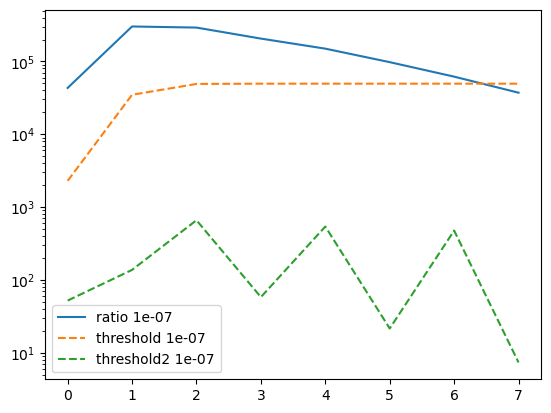

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-06
6.450452080978621e-05
	  	 2 	 	 2.983e+04 	 1.551e+03 	 3.371e+01
	  	 3 	 	 2.838e+04 	 4.221e+03 	 1.304e+01
	  	 4 	 	 2.663e+04 	 4.375e+03 	 5.837e+01
	  	 5 	 	 1.921e+04 	 4.378e+03 	 5.130e+00
	  	 6 	 	 1.420e+04 	 4.378e+03 	 4.776e+01
	  	 7 	 	 9.204e+03 	 4.378e+03 	 1.903e+00
	  	 8 	 	 5.617e+03 	 4.378e+03 	 4.203e+01
	  	 9 	 	 3.271e+03 	 4.378e+03 	 6.490e-01


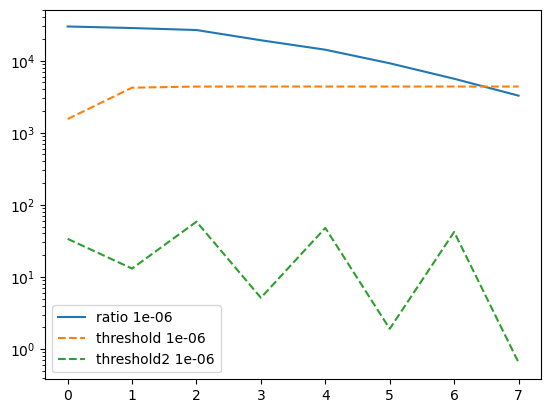

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
1e-05
0.0006344773380843596
	  	 2 	 	 4.409e+03 	 3.766e+02 	 7.682e+00
	  	 3 	 	 2.846e+03 	 4.450e+02 	 1.339e+00
	  	 4 	 	 2.626e+03 	 4.467e+02 	 5.956e+00
	  	 5 	 	 1.872e+03 	 4.467e+02 	 5.235e-01
	  	 6 	 	 1.344e+03 	 4.467e+02 	 4.873e+00
	  	 7 	 	 8.701e+02 	 4.467e+02 	 1.941e-01
	  	 8 	 	 5.463e+02 	 4.467e+02 	 4.288e+00
	  	 9 	 	 3.316e+02 	 4.467e+02 	 6.622e-02


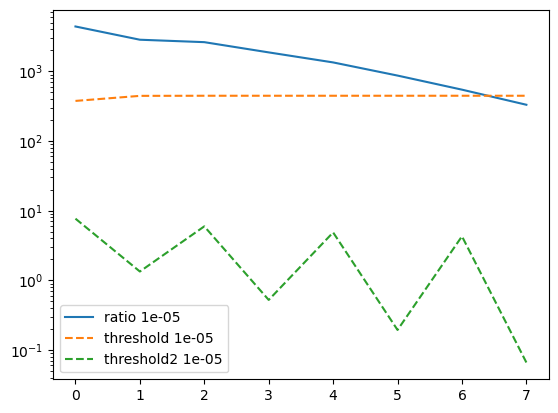

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
0.0001
0.006352644322682196
	  	 2 	 	 4.813e+02 	 4.263e+01 	 8.544e-01
	  	 3 	 	 2.945e+02 	 4.338e+01 	 1.302e-01
	  	 4 	 	 2.777e+02 	 4.340e+01 	 5.786e-01
	  	 5 	 	 2.002e+02 	 4.340e+01 	 5.086e-02
	  	 6 	 	 1.479e+02 	 4.340e+01 	 4.734e-01
	  	 7 	 	 9.524e+01 	 4.340e+01 	 1.886e-02
	  	 8 	 	 5.789e+01 	 4.340e+01 	 4.166e-01
	  	 9 	 	 3.383e+01 	 4.340e+01 	 6.434e-03


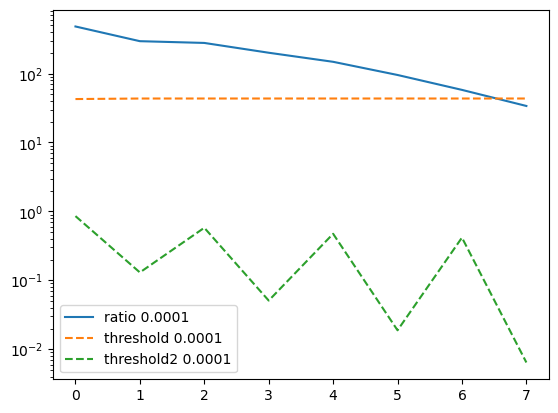

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
0.001
0.06292016133680163
	  	 2 	 	 4.680e+01 	 4.487e+00 	 8.975e-02
	  	 3 	 	 2.900e+01 	 4.495e+00 	 1.348e-02
	  	 4 	 	 2.633e+01 	 4.495e+00 	 5.993e-02
	  	 5 	 	 1.842e+01 	 4.495e+00 	 5.268e-03
	  	 6 	 	 1.312e+01 	 4.495e+00 	 4.904e-02
	  	 7 	 	 8.676e+00 	 4.495e+00 	 1.954e-03
	  	 8 	 	 5.681e+00 	 4.495e+00 	 4.315e-02
	  	 9 	 	 3.740e+00 	 4.495e+00 	 6.664e-04


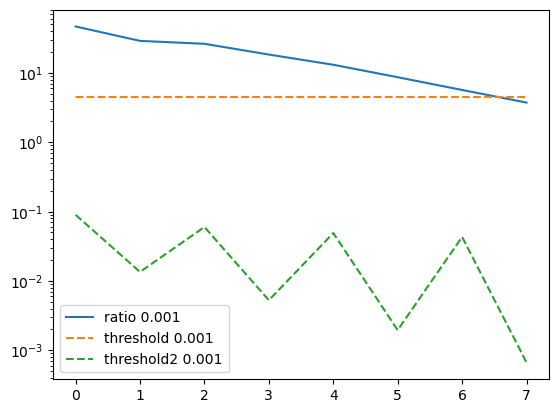

Noise level 	 order 	 	 ratio 	 	 threshold 	 	 threshold2
0.01
0.6384667038564634
	  	 2 	 	 4.983e+00 	 4.459e-01 	 8.918e-03
	  	 3 	 	 3.302e+00 	 4.460e-01 	 1.338e-03
	  	 4 	 	 3.223e+00 	 4.460e-01 	 5.946e-03
	  	 5 	 	 2.629e+00 	 4.460e-01 	 5.226e-04
	  	 6 	 	 2.442e+00 	 4.460e-01 	 4.865e-03
	  	 7 	 	 2.728e+00 	 4.460e-01 	 1.938e-04
	  	 8 	 	 3.736e+00 	 4.460e-01 	 4.281e-03
	  	 9 	 	 5.762e+00 	 4.460e-01 	 6.611e-05


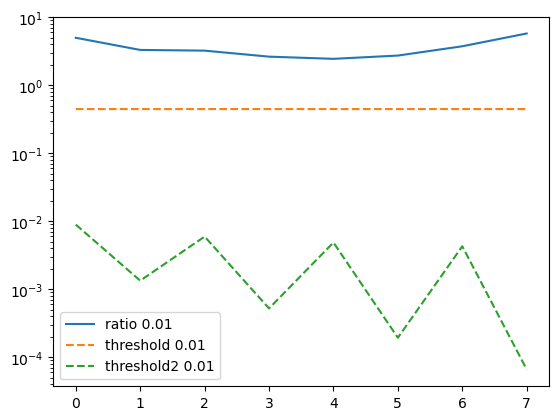

In [7]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t \t threshold2")
    print(f"{target_noise}")
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_infty = infinity_norm(u-u_noise)
    eps_two = np.linalg.norm(u-u_noise)
    
    for order in orders:          
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        
        ratio=sv[0]/sv[-1]
        threshold = calc_threshold(eps_infty,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2 = calc_threshold2( eps_two,eps_infty,dx,true_g.shape[0],M,order)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)
        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Uniqueness

##### We try if the threshold also holds for unqiue values
We choose $C_1>0$ and $C_n>0$ such that $\sigma_n \geq \frac{1}{C_1}, \ \sigma_1 \leq C_n$. Then
$$\frac{\tilde\sigma_1}{\tilde\sigma_n} \leq C_1 C_2+ C_1 \sqrt{1 + (C_1 C_2)^2}\|G-\tilde{G}\|_F \leq C_1 C_2+ C_1 \sqrt{1 + (C_1 C_2)^2}\sqrt{E}$$
Additionally we know $\frac{\tilde\sigma_1}{\tilde\sigma_n}\geq 1$

In [22]:
"""
def calc_threshold_uniq(eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_meas=meas_error_backward_diff(order)
    return (eps/h+h**order)*1e8
"""    
def calc_threshold_uniq(C1,C2,eps,h,order=2):
    E = (eps/h+h**order)
    T = C1*C2 + C1*np.sqrt(1+ (C1*C2)**2)*np.sqrt(E)
    return T
def calc_threshold_uniq2(C1,C2,eps_two,eps_infty,M,h,number_datapoints,order=2):
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    T = C1*C2 + C1*np.sqrt(1+ (C1*C2)**2)*np.sqrt(E)
    return T

In [23]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=5, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C
"""
u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut

dx=x[1]-x[0]

In [24]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 5.000505973884352
Singular values of g: (260.85163645537597, 78.24490469281811)
sv_max/sv_min: 3.334e+00


True ratio: 3.334e+00
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
	  	 2 	 	 3.334e+00 	 7.008e+01 	 3.000e+00
	  	 3 	 	 3.334e+00 	 2.084e+01 	 3.000e+00
	  	 4 	 	 3.334e+00 	 7.743e+00 	 3.000e+00
	  	 5 	 	 3.334e+00 	 4.261e+00 	 3.000e+00
	  	 6 	 	 3.334e+00 	 3.335e+00 	 3.000e+00
	  	 7 	 	 3.334e+00 	 3.089e+00 	 3.000e+00
	  	 8 	 	 3.334e+00 	 3.024e+00 	 3.000e+00
	  	 9 	 	 3.334e+00 	 3.006e+00 	 3.000e+00


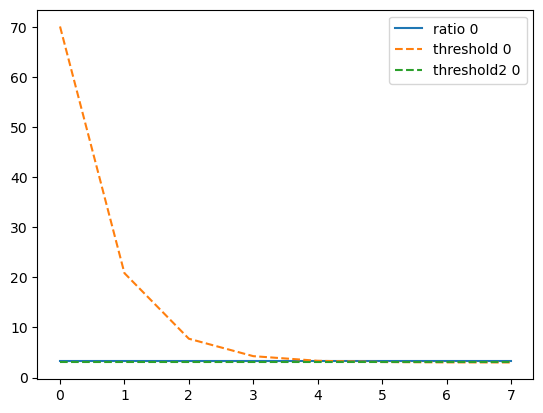

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
2.53537735235275e-08
	  	 2 	 	 3.334e+00 	 7.008e+01 	 3.001e+00
	  	 3 	 	 3.334e+00 	 2.085e+01 	 3.010e+00
	  	 4 	 	 3.334e+00 	 7.777e+00 	 3.002e+00
	  	 5 	 	 3.334e+00 	 4.383e+00 	 3.025e+00
	  	 6 	 	 3.334e+00 	 3.660e+00 	 3.003e+00
	  	 7 	 	 3.334e+00 	 3.575e+00 	 3.068e+00
	  	 8 	 	 3.334e+00 	 3.569e+00 	 3.003e+00
	  	 9 	 	 3.334e+00 	 3.568e+00 	 3.198e+00


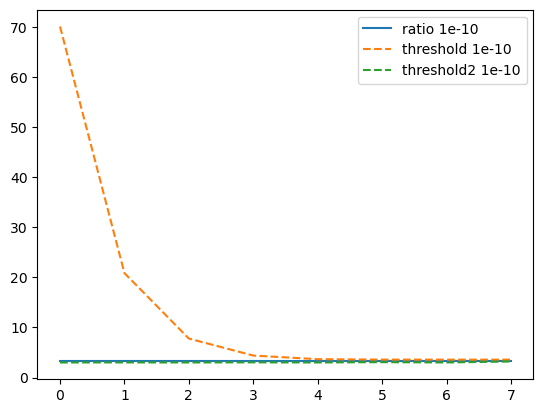

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
2.534407474097247e-07
	  	 2 	 	 3.334e+00 	 7.010e+01 	 3.014e+00
	  	 3 	 	 3.334e+00 	 2.093e+01 	 3.094e+00
	  	 4 	 	 3.334e+00 	 8.072e+00 	 3.021e+00
	  	 5 	 	 3.334e+00 	 5.195e+00 	 3.241e+00
	  	 6 	 	 3.334e+00 	 4.827e+00 	 3.026e+00
	  	 7 	 	 3.334e+00 	 4.798e+00 	 3.650e+00
	  	 8 	 	 3.334e+00 	 4.796e+00 	 3.029e+00
	  	 9 	 	 3.334e+00 	 4.796e+00 	 4.906e+00


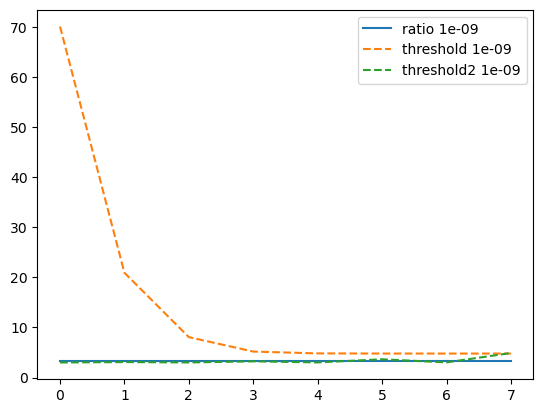

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
2.5273207542222755e-06
	  	 2 	 	 3.334e+00 	 7.032e+01 	 3.134e+00
	  	 3 	 	 3.334e+00 	 2.172e+01 	 3.896e+00
	  	 4 	 	 3.334e+00 	 1.039e+01 	 3.202e+00
	  	 5 	 	 3.334e+00 	 8.810e+00 	 5.294e+00
	  	 6 	 	 3.334e+00 	 8.682e+00 	 3.246e+00
	  	 7 	 	 3.334e+00 	 8.672e+00 	 9.185e+00
	  	 8 	 	 3.334e+00 	 8.672e+00 	 3.280e+00
	  	 9 	 	 3.334e+00 	 8.672e+00 	 2.113e+01


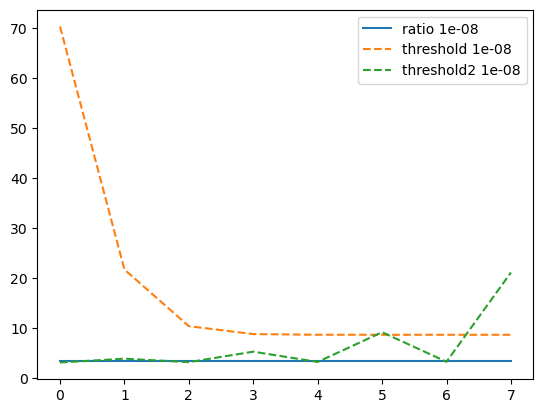

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
2.5106696882004705e-05
	  	 2 	 	 3.334e+00 	 7.242e+01 	 4.273e+00
	  	 3 	 	 3.334e+00 	 2.825e+01 	 1.149e+01
	  	 4 	 	 3.334e+00 	 2.150e+01 	 4.910e+00
	  	 5 	 	 3.334e+00 	 2.092e+01 	 2.473e+01
	  	 6 	 	 3.334e+00 	 2.088e+01 	 5.334e+00
	  	 7 	 	 3.334e+00 	 2.088e+01 	 6.159e+01
	  	 8 	 	 3.334e+00 	 2.088e+01 	 5.652e+00
	  	 9 	 	 3.334e+00 	 2.088e+01 	 1.748e+02


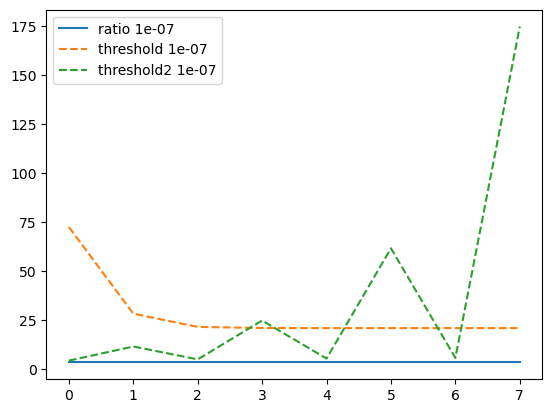

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
0.0002520170171402714
	  	 2 	 	 3.334e+00 	 9.079e+01 	 1.554e+01
	  	 3 	 	 3.334e+00 	 6.238e+01 	 8.656e+01
	  	 4 	 	 3.334e+00 	 5.984e+01 	 2.180e+01
	  	 5 	 	 3.334e+00 	 5.965e+01 	 2.169e+02
	  	 6 	 	 3.334e+00 	 5.964e+01 	 2.598e+01
	  	 7 	 	 3.334e+00 	 5.964e+01 	 5.798e+02
	  	 8 	 	 3.334e+00 	 5.964e+01 	 2.911e+01
	  	 9 	 	 3.334e+00 	 5.964e+01 	 1.694e+03


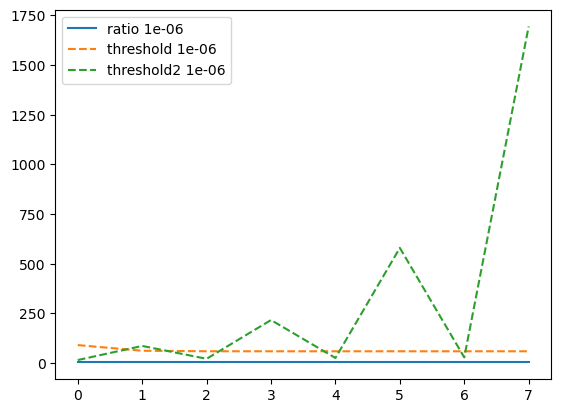

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.0025486632907142023
	  	 2 	 	 3.334e+00 	 1.952e+02 	 1.254e+02
	  	 3 	 	 3.334e+00 	 1.840e+02 	 8.186e+02
	  	 4 	 	 3.334e+00 	 1.832e+02 	 1.865e+02
	  	 5 	 	 3.334e+00 	 1.831e+02 	 2.091e+03
	  	 6 	 	 3.334e+00 	 1.831e+02 	 2.273e+02
	  	 7 	 	 3.334e+00 	 1.831e+02 	 5.633e+03
	  	 8 	 	 3.334e+00 	 1.831e+02 	 2.579e+02
	  	 9 	 	 3.334e+00 	 1.831e+02 	 1.651e+04


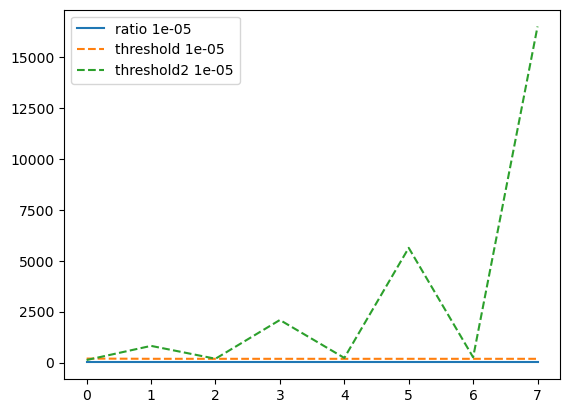

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.025181095778215114
	  	 2 	 	 3.334e+00 	 5.731e+02 	 1.254e+03
	  	 3 	 	 3.334e+00 	 5.694e+02 	 8.341e+03
	  	 4 	 	 3.334e+00 	 5.692e+02 	 1.879e+03
	  	 5 	 	 3.334e+00 	 5.691e+02 	 2.135e+04
	  	 6 	 	 3.333e+00 	 5.691e+02 	 2.296e+03
	  	 7 	 	 3.333e+00 	 5.691e+02 	 5.756e+04
	  	 8 	 	 3.333e+00 	 5.691e+02 	 2.609e+03
	  	 9 	 	 3.332e+00 	 5.691e+02 	 1.687e+05


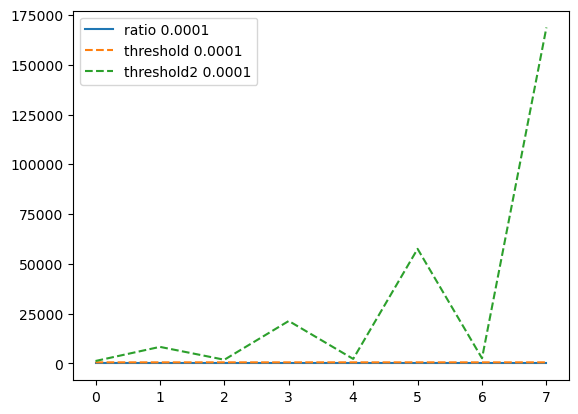

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.2539510739779975
	  	 2 	 	 3.332e+00 	 1.802e+03 	 1.431e+04
	  	 3 	 	 3.329e+00 	 1.801e+03 	 9.535e+04
	  	 4 	 	 3.329e+00 	 1.801e+03 	 2.146e+04
	  	 5 	 	 3.325e+00 	 1.801e+03 	 2.441e+05
	  	 6 	 	 3.320e+00 	 1.801e+03 	 2.622e+04
	  	 7 	 	 3.304e+00 	 1.801e+03 	 6.581e+05
	  	 8 	 	 3.260e+00 	 1.801e+03 	 2.980e+04
	  	 9 	 	 3.138e+00 	 1.801e+03 	 1.929e+06


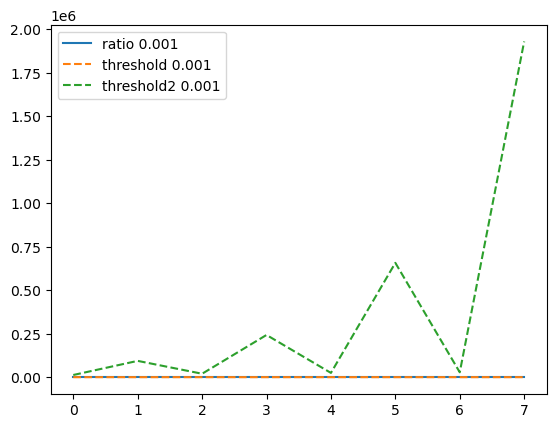

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
2.544467504155904
	  	 2 	 	 3.148e+00 	 5.694e+03 	 1.498e+05
	  	 3 	 	 2.901e+00 	 5.694e+03 	 9.986e+05
	  	 4 	 	 2.949e+00 	 5.694e+03 	 2.247e+05
	  	 5 	 	 2.726e+00 	 5.694e+03 	 2.556e+06
	  	 6 	 	 2.526e+00 	 5.694e+03 	 2.746e+05
	  	 7 	 	 2.064e+00 	 5.694e+03 	 6.893e+06
	  	 8 	 	 1.531e+00 	 5.694e+03 	 3.121e+05
	  	 9 	 	 1.305e+00 	 5.694e+03 	 2.021e+07


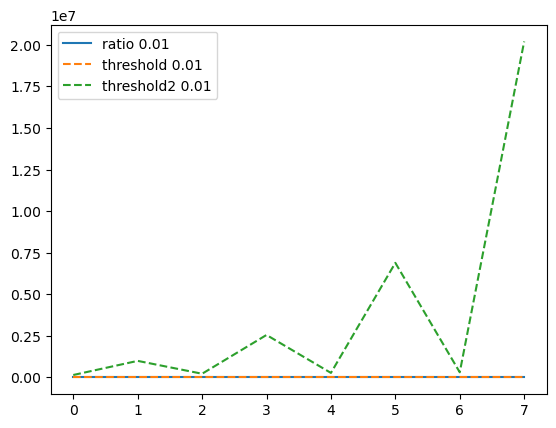

In [36]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))
C1=300#sv_max
C2=1/100#1/sv_min

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)
    
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        threshold = calc_threshold_uniq(C1,C2,eps_two,dx,order)
        threshold2 = calc_threshold_uniq2(C1,C2,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)

        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    #plt.yscale('log')
    plt.legend()
    plt.show()